# Data 201

Data Wrangling, S2 2021

## Assignement 2

### 20% of final grade

## Due date: 2pm Tuesday 12 October 2021

The assignment must be submitted on the DATA 201 and 422 Learn page and should be **your own pair** (or group of three if we are odd) **work**. Avoid plagiarism: if you are not sure what may constitute code plagiarism, read this http://web.science.mq.edu.au/~mtaylor/ponline/index.php?id=source-code-plagiarism. Remember, when in doubt **declare your sources**.  
As a general rule, late submission are **highly** unsuggested. The pace of the course is very quick, and you don't want to be working on this too long, as you would have less time for other assignments. I suggest you to submit what you have ready by the time the assignment is due, even if it is not everything we required. For any particular problem, please contact [Thomas Li](thomas.li@canterbury.ac.nz) or [Giulio Dalla Riva](giulio.dallariva@canterbury.ac.nz) or TAs.


## Instruction

### Total: 20 marks.

For this assignment you will work with data from the web. Your goal is to scrape it or request it, wrangle it, produce some plotting, in order to demonstrate that you are able to use the functions, plotting, and markdown format we have been learning.  
You shall hand in your work as a jupyter R notebook comprehending the code, the plots and, **very important**, enough comments and explanations for us to understand what you did, how you did it, and why you did it. Remember: better comments, means better marks.  
You can either modify this notebook or write a new one from scratch.

Do use the tidyverse syntax that's introduced in class and labs. If in doubt, refresh the lab material 1 to 7.

### Task (a): scrape it (5 marks)

Identify a website page showing information you find interesting. The information should be presented across more than one page. Select one of this pages (the rest is for later) and using `rvest` (and the suit of `tidyverse` libraries we used so far, plus any other one you may need) get the html into R.

tidyverse: collection of R packages
rvest: read webpage and expore content.

# Load Libraries

In [2]:
library(tidyverse)
library(rvest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




# Information about data scraped.
We will attempt to scrape UC's lecture database followed by informationa about lecturers involved in each lecture.

For this we will get information from 4 different sources:

## Subject List
This page contains all the subjects given by UC, we will use this list to access information about the lectures given by subject.

https://www.canterbury.ac.nz/courseinfo/subjects.aspx
![Course List](course_list.png "Course List")


## Course information List
This page lists the lectures given by a specific subject.

https://www.canterbury.ac.nz/courseinfo/GetCourses.aspx?subjectnames=French&viewby=subject&year2022
![Course Information List](course_list_detail.png "Course Information List")


## Course Detail Page
This page contains the detail information about the lecture.

https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=EURA234&occurrence=22S1(C)&year=2022
![Course Detail](course_detail.png "Course Detail")


## Lecturer Detail Page
This page contains information about UC Staff.

https://www.canterbury.ac.nz/arts/contact-us/people/serena-kelly.html
![Lecturer Detail](lecturer_detail.png "Lecturer Detail")




# Lecturer Functions.
 We will start by defining functions to retrieve information about Lecturers.

In [5]:
get_lecturer <- function(url){  # receives a lecturer detail url and returns information about the lecturer
    header <- 'div.staff-profile-header' # lecturer selector, it is a div with staff-profile-header class.
    tryCatch( { 
        page <- url %>% read_html()  # we attempt to get the url, if we fail we just return an empty vector.
        header_object <- page %>% html_node(header)
    }, error = function(e){
        return(c(NA, NA, NA, NA))
    }
    )
    if(!exists("header_object")){ # if header object is not there then there is no information we can gather from this Lecturer.
        return(c(NA, NA, NA, NA))
    }
    if (is.na(header_object) | is.null(header_object)) { # if the header object is NA or NULL there is nothing we can do with this lecturer
        data <-  c(NA, NA, NA, NA);
    }else{
        email <- page %>% html_node('.staff-profile-email') %>% html_text()  # get the email address
        title <- header_object %>% html_node('h2') %>% html_node('span') %>% html_text() # get the title (Lecturer, Coordinator, etc)
        room <- header_object %>% html_node('.col-sm-8 div:nth-child(6)') %>% html_text() # get their office room
        phone <- header_object %>% html_node('.col-sm-8 div:nth-child(7)') %>% html_text() # get their phone number
        data <- c(email, title, room, phone) #add everything to a vector and return it.
    }
    return(data)
}

In [3]:
base_lecturer_url <- 'https://www.canterbury.ac.nz/courseinfo/' # base url for lecturer information
get_lecturers <- function(course_body, course_code) { # This function receives an html body of a course information page and the course code
                                                      # returns all the lecturers involved in this course
    lecturer_links <- course_body %>%                 
                      html_element('#ctl00_ContentPlaceHolder1_ContributorsDiv') %>% #find the lecturer place holder
                      html_elements('a')
    names = c() #initialize arrays to store information about lecturers.
    links = c()
    emails = c()
    titles = c()
    rooms = c()
    phones = c()
    for (lecturer in lecturer_links){ # for every link we will attempt to get information about the lecturer
        name <- lecturer %>% html_text()
        link <- lecturer %>% html_attr('href')

        if (is.na(link)){ # check that the lecturer actually has a link to it, if not, keep going because there is nothing to scrape from it.
            next
        }
        
        if (endsWith(link, 'contact-us')){ #if the link ends in contact-us then it just sends us to a default form page, not useful for what we need.
            link <- NA;
        }
        
        if (startsWith(link, 'ShowPeopleDetails')){ # if the link ends in ShowPeopleDetails then it is just a simple contact page but it is only a URI
            link <- paste(base_lecturer_url, link, sep='')  # so we need to concatenate it with the base_lecturer_link
        }
        
        if (name == 'Language, Social and Political Sciences'){ # There is an exception of a form in this page that does not allow us to continue scraping
            name <- NA
        }
        
        if(!is.na(name)){ # if we have a name we add all the information about the lecturer to our information vector
            names <- c(names, name)
            links <- c(links, link)
            lecturer_data = get_lecturer(link) # we call the get_lecturer function to go to the lecturer detail page and grab all the information we can.
            emails <- c(emails, lecturer_data[1])
            titles <- c(titles, lecturer_data[2])
            rooms <- c(rooms, lecturer_data[3])
            phones <- c(phones, lecturer_data[4])   
        }
    }
    return(tibble(course_code=course_code, names=names, links=links, emails=emails, titles=titles, rooms=rooms, phones=phones))
}


Now we will define functions to get information about Subjects and Courses

In [6]:
get_text <- function(element, selector){ # Extracts text from a selected element based on predefined criteria.
        text_need <- element %>%
                     html_elements(selector) %>%
                     html_text()
        return(text_need)
    }

get_detail <- function(detail_url){  # given a detail url extract all the information about the course posible
    
    url_readed <- detail_url %>% read_html() # reads html from url 
    node_selector <- "#ctl00_ContentPlaceHolder1_CourseCodeLabel" # Selects a node 
    course_code <- get_text(url_readed, node_selector) # gets information from that noode
    if (identical(course_code, character(0))){ # checks if the node is empty and if it is assigns it as NULL
        course_code = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_CourseOccurrenceTitleLabel"
    course_name <- get_text(url_readed, node_selector)
    if (identical(course_name, character(0))){
        course_name = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_DomesticFeeLabel"
    Domestic_fee <- get_text(url_readed, node_selector)
    if (identical(Domestic_fee, character(0))){
        Domestic_fee = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_InternationalFeeLabel"
    International_fee <- get_text(url_readed, node_selector)
    if (identical(International_fee, character(0))){
        International_fee = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_StartDateLabel"
    Start_date <- get_text(url_readed, node_selector)
    if (identical(Start_date, character(0))){
        Start_date = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_EndDateLabel"
    End_date <- get_text(url_readed, node_selector)
    if (identical(End_date, character(0))){
        End_date = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_PointsAndEftsLabel"
    Points <- get_text(url_readed, node_selector)
    if (identical(Points, character(0))){
        Points = 'NULL'
    }
    lecturers <- get_lecturers(url_readed, course_code) # gets information about the lecturer for the given course.
                                                        # This function is here and nested in order to not scrape the same course url twice
                                                        # to save resources and time.
    return(list(course_code, course_name, Domestic_fee, International_fee, Start_date, End_date, Points, lecturers))
}

get_course_details <- function(subject_url){  # gets information about a course based on a subject url
    new_table <- data.frame("course_code"=0, "course_name"=0,  #creates an empty dataframe to store information about the course
                            "domestic_fee"=0, "international_fee"=0,  
                            "start_date"=0, "end_date"=0, 
                            "points"=0, 'link'=0)
    
    tryCatch(  #attempts to gather information about the course, this is inside a try catch in order to handle 500/404 http errors.
        { 
            read_url_subjects <- subject_url %>% read_html()
            all_links <- read_url_subjects %>% html_element("#GetCourses") %>% html_elements('a')
        }, error = function(e){
            return(c(new_table, c(NA, NA, NA, NA)))
        }
    )
    if (!exists('all_links')){ # if the scrape was unsuccessfull just return an empty vector
        return(c(new_table, c(NA, NA, NA, NA)))
    }
    if (length(all_links) == 0 ){ # if the length of the details is 0 return an empty vector
        return(c(new_table, c(NA, NA, NA, NA)))
    }else{
        table_a_tage <- bind_rows(lapply(html_attrs(all_links),  #creates a list to iterate over 
                                  function(x) data.frame(as.list(x), stringsAsFactors=FALSE)))
    }
    prefix <- "https://www.canterbury.ac.nz/courseinfo/" # base courseinfo url.
    table_a_tage_without_na <- table_a_tage[3] %>% 
                               filter(href!="NA") %>% 
                               mutate(href = str_c(prefix, href))    #filters links without value and adds the courseinfo prefix to them
    max_row <- nrow(table_a_tage_without_na) # gets max amount of items to iterate over.
    lecturer_list = c() # creates an empty vector to save information about the lecturers
    for (i in 1:max_row){
         row <- table_a_tage_without_na[i,]
         detail <- row %>% get_detail() # gets the detail for the given subject
         lecturer_list <- c(lecturer_list, detail[8]) # position 8 of the detail is the lecturer information , we add this to our lecturer_list
         new_table[nrow(new_table) + 1,] = c(detail[1], # course code
                                             detail[2], # course name
                                             detail[3], # domestic fee
                                             detail[4], # international fee
                                             detail[5], # start date
                                             detail[6], #end date
                                             detail[7], # points
                                             row)
    }
    parsed_table <- parsed_table[-1,] # we get rid of the first row.
    lecturer_list <- lecturer_list %>% bind_rows() %>% as.data.frame() # we bind the lecturer vector into a data frame.
    return(list(parsed_table, lecturer_list))  # 
}



In [6]:
url_adreess_subjects <- "https://www.canterbury.ac.nz/courseinfo/subjects.aspx" # base subject URL

get_all_courses <- function(subjects_url){
    subjects = c()
    lecturers = c()
    url_subjects_a <- url_adreess_subjects %>% 
                      read_html() %>% # scrapes URL to get HTML 
                      html_elements('.row') %>%  #find all elements with row class.
                      html_elements('.col-md-6') %>% # find all children with col-md-6 class
                      html_elements('a') # get the links
    table_a_tage <- bind_rows(lapply(html_attrs(url_subjects_a),
                                     function(x) data.frame(as.list(x), stringsAsFactors=FALSE))) #stores all links in a data_frame to iterate over.
   
    max_row <- nrow(table_a_tage) # gets the number of items to iterate over.
    
    prefix_subject <- "https://www.canterbury.ac.nz/courseinfo/" # base course info url
    for(i in 1:max_row){ # we will go through all link to get the course information
        one_subject_url <- table_a_tage[i,2] %>% 
                           str_c(prefix_subject,.) %>%
                           str_replace_all(" ", "%20") # gets the url of the current subject
        course_info <- get_course_details(one_subject_url) # calls course_detail in order to get all the information for the course. 
        if (lengths(course_info[1]) == 1){ # if the course info is empty just skip to the next one
            next
        }
        tryCatch({ 
            subjects <- c(subjects, course_info[1]) # tries to add rows to the subject and lecturer list, this could fail based on errors while scraping.
            lecturers <- c(lecturers, course_info[2])
        }, error = function(e){})

    }
    lecturers <- lecturers %>% bind_rows() # concatenate all items from the lecturer list into a dataframe
    subjects <- subjects %>% bind_rows() # concatenate all the items in the subject list into a dataframe.
    return(list(subjects, lecturers))
                                     
}


### Task (b): wrangle it (5 marks)


Working on the page from task (a), transform the data you collected into relational data model (that is, one or more data frames). WARNING: you will need to think and motivate how you are doing this in terms of the **data model** you are trying to build; just throwing everything in a table is not enough.

Firs we will read from saved csv's from previous tests in order to make the wrangle process faster.

In [9]:
lecturers <- read.csv('lecturers_raw.csv')
subjects <- read.csv('subjects_raw.csv')

We will make 3 related dataframes from the scraped data: Subject information, Lecturer Information, Lecturer-Subject relation dataframe.

Let's have a look at how the dataframes look

In [14]:
lecturers %>% sample_n(3)
subjects %>% sample_n(3)

X,course_code,names,links,emails,titles,rooms,phones
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1041,PHIL250-21S2 (C),Jack Copeland,https://www.canterbury.ac.nz/arts/contact-us/people/jack-copeland.html,jack.copeland@canterbury.ac.nz,Distinguished Professor,Karl Popper 619,Phone: +6433695637
226,MAOR172-21S2 (C),Hamuera Kahi,https://www.canterbury.ac.nz/arts/schools-and-departments/aotahi-school-of-maori-and-indigenous-studies/contact-us/key-contacts/hamuera-kahi.html,hamuera.kahi@canterbury.ac.nz,Lecturer in Maori and Indigenous Studies,Te Ao Marama 159,Phone: +6433692239
3815,PROD612-21S2 (C),NA,NA,NA,NA,NA,NA


X,course_code,course_name,domestic_fee,international_fee,start_date,end_date,points,link
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2818,ANTH223-21S2 (C),"Ethnicity, Racism and History",$785.00,"$3,500.00","Monday, 19 July 2021","Sunday, 14 November 2021",15 points,https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=ANTH223&occurrence=21S2(C)&year=2021
1019,ENGR407-21S2 (C),Bioprocess Engineering 1,$986.00,"$5,500.00","Monday, 19 July 2021","Sunday, 14 November 2021",15 points,https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=ENGR407&occurrence=21S2(C)&year=2021
606,DATA101-21S2 (D),Introduction to Data Science,$910.00,"$4,438.00","Monday, 19 July 2021","Sunday, 14 November 2021",15 points,https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=DATA101&occurrence=21S2(D)&year=2021


Now lets get the information we need and store them in a clean way.

In [38]:
class_data <- lecturers %>% select(X, course_code, names) # Gets the course information for classes.

lecturer_information <- lecturers %>% distinct(names, links, .keep_all=TRUE) %>% # we make sure the lecturers are distinct( 1 lecturer could be involved in more than 1 course)
                                      select(names, links, emails, titles, rooms, phones) %>% # we just need the information about the lecturer, nothing else.
                                      na.omit(names) # we omit empty lecturers.

lecturer_information$id = seq.int(nrow(lecturer_information)) # we add a new sequential id to lecturers in order to make them unique

class_data <- class_data %>% merge(lecturer_information) # we now merge the lecturer information with the class data.

class_data <- class_data %>% mutate(names=id) %>% 
                             select(course_code, names) %>% 
                             rename(lecturer_id=names) # we turn the lecturer name into an ID referencing the lecturer_information dataset.

lecturer_information <- lecturer_information %>% select(id, names, emails, titles, rooms, phones) %>% 
                                                 rename(name=names,  # doing some clean up of names in order to be consistent.
                                                        email=emails,
                                                        title=titles,
                                                        room=rooms, 
                                                        phone=phones,
                                                        )


lecturer_information <- lecturer_information %>% mutate(phone=str_remove(phone, 'Phone:')) # remove unecesary Phone string in telepphones

subjects <- subjects %>% na.omit(course_code) %>% 
                          mutate(points=str_remove(points, 'points'), # remove unnecesary points string in credits/points
                           domestic_fee=substr(domestic_fee, 2, length(domestic_fee)),  # remove $ sign
                           international_fee=substr(international_fee, 2, length(domestic_fee)), # remove $ sign
                           semester=unlist(str_split(course_code, '-'))[2], # extract the semester from the course code
                           attendance=ifelse(grepl("(C)", course_code), TRUE, FALSE), # extract attendance from the course code (C) or (D)
                           semester=substr(semester, 3, 4) # get the semester info from the course code
                   )

lecturer_information %>% sample_n(3)
subjects %>% sample_n(3)
class_data %>% sample_n(3)

id,name,email,title,room,phone
<int>,<chr>,<chr>,<chr>,<chr>,<chr>
49,Phillip Borell,phillip.borell@canterbury.ac.nz,Lecturer in Te Maori and Maori Performing Arts,Te Ao Marama 162,+6433695957
21,Luis Apiolaza,luis.apiolaza@canterbury.ac.nz,Associate Professor,School of Forestry Rm 133,+6433695998
307,Shea Esterling,shea.esterling@canterbury.ac.nz,Senior Lecturer,Meremere 415,+6433694128


X,course_code,course_name,domestic_fee,international_fee,start_date,end_date,points,link,semester,attendance
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
3996,MCED602-21X1 (E),Better Start Literacy Approach for Teachers: Evidence-based practice in early literacy teaching instruction,,,"Monday, 8 March 2021","Sunday, 17 April 2022",5,https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=MCED602&occurrence=21X1(E)&year=2021,S1,TRUE
2350,PHIL496-21T4 (C),Cognitive Science,,,"Monday, 6 September 2021","Sunday, 7 November 2021",30,https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=PHIL496&year=2021,S1,TRUE
4480,ENCN347-21S2 (C),Stormwater systems engineering,,,"Monday, 19 July 2021","Sunday, 14 November 2021",15,https://www.canterbury.ac.nz/courseinfo/GetCourseDetails.aspx?course=ENCN347&occurrence=21S2(C)&year=2021,S1,TRUE


course_code,lecturer_id
<chr>,<int>
ENCH298-21S1 (C),355
PROD631-21S2 (C),331
ENEL481-21S2 (C),151


### Task (c): automate it (5 marks)

Now it's the time to scrape everything else in the website. Turn your code for tasks (a) and (b) into a function and using `purrr` (and its `map_` functions, possibly in combination with `possibly`) apply that function to all the pages you are interested in (as we have done in lab 6); the output of the task should be a relation dataset (i.e., one or more dataframes, and if more than one, explicit their relationships).

In [23]:
course_data <- get_all_courses(url_adreess_subjects)
#write.csv(as.data.frame(course_data[1]), 'subjects_raw.csv')
#write.csv(as.data.frame(course_data[2]), 'lecturers_raw.csv')


lecturers <- read.csv('lecturers_raw.csv')
subjects <- read.csv('subjects_raw.csv')### Task (d): plot it (2 marks)

Use graphics (via `ggplot`) to represent the data you collected in a meaningful way.

In [7]:
lecturers <- read.csv('lecturers_raw.csv')
subjects <- read.csv('subjects_raw.csv')

First we add some default settings to our plots

In [42]:
options(repr.plot.width=15, repr.plot.height=15, repr.plot.pointsize=1000) # Setting plot size as a global option.

base_theme <- theme(plot.title=element_text(size=30), # Setting a default size for all text in our plots.
                    axis.title=element_text(size=30),
                    axis.text.x=element_text(size=15),
                    axis.text.y=element_text(size=15),
                    legend.title=element_text(size=25),
                    legend.text=element_text(size=20)) 



Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 3 rows containing missing values (geom_text).”


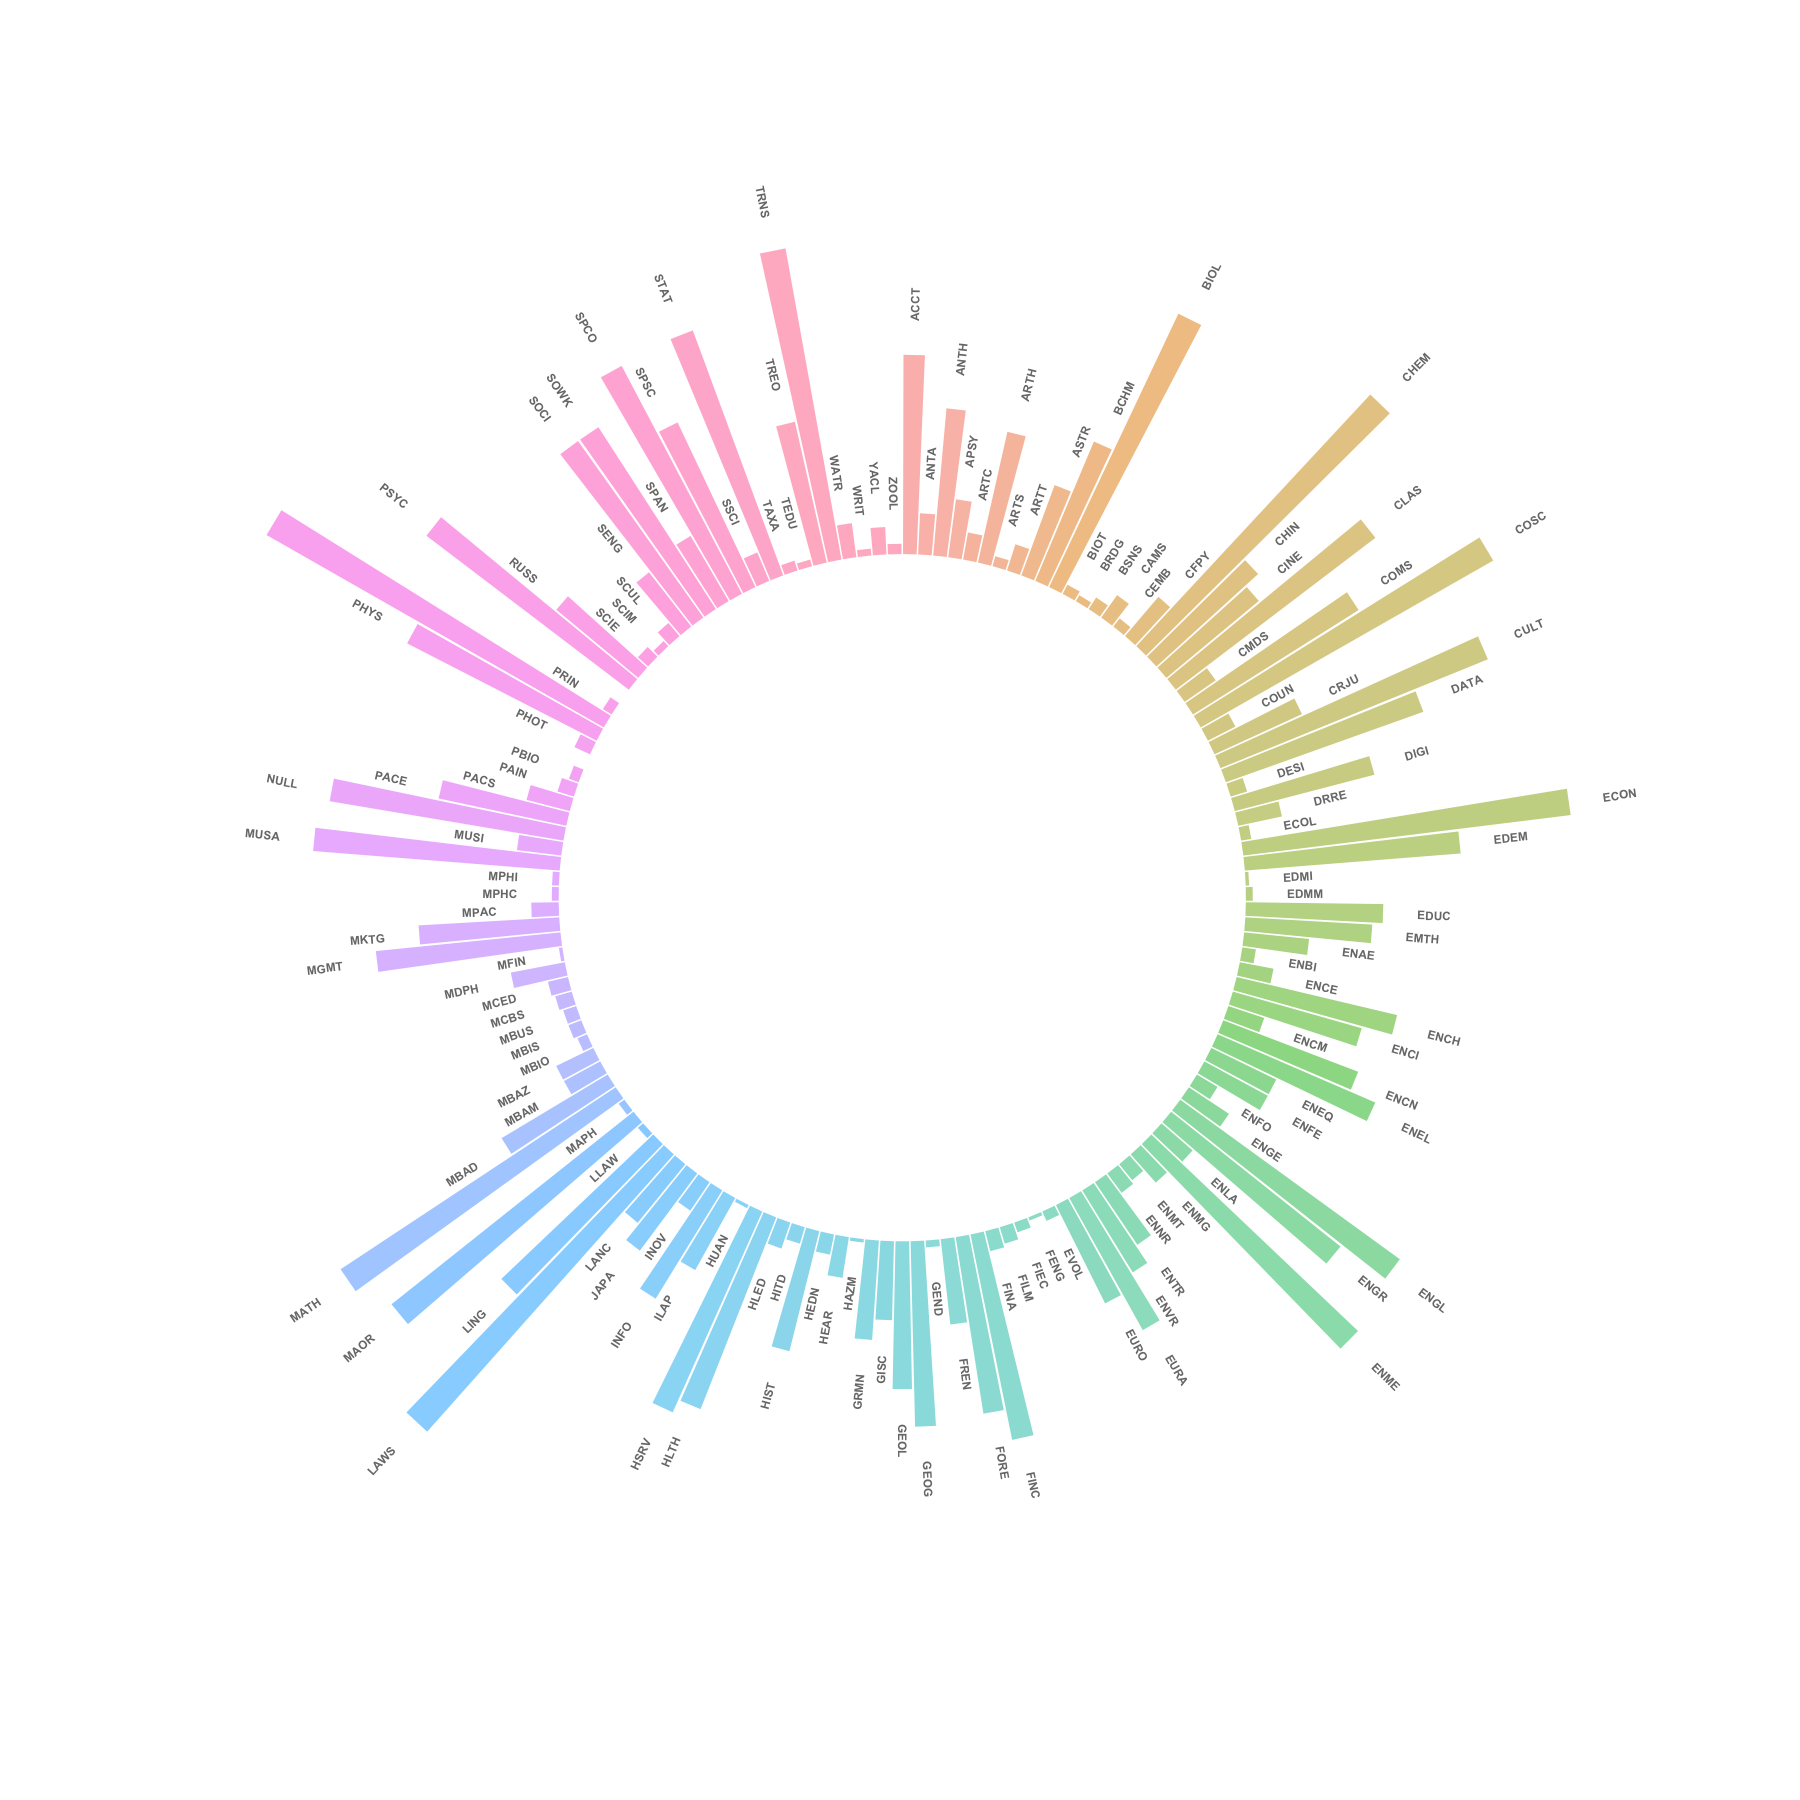

In [46]:
data <- subjects %>% 
             select(course_code) %>% 
             rename(subject_name = course_code) %>% 
             mutate(subject_name = substr(subject_name, 1,4)) %>% 
             group_by(subject_name) %>% 
             summarise(courses_in_subject=n(), per=courses_in_subject/nrow(subjects)) %>%
             mutate(labels = scales::percent(per))


# Set a number of 'empty bar' to add at the end of each group
empty_bar <- 4
to_add <- data.frame( matrix(NA, empty_bar*nlevels(data$subject_name), ncol(data)) )
colnames(to_add) <- colnames(data)
to_add$subject_name <- rep(levels(data$subject_name), each=empty_bar)
data <- rbind(data, to_add)
data <- data %>% arrange(subject_name)
data$id <- seq(1, nrow(data))

 
# Get the name and the y position of each label
label_data <- data
number_of_bar <- nrow(label_data)
angle <- 90 - 360 * (label_data$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_data$hjust <- ifelse( angle < -90, 1, 0)
label_data$angle <- ifelse(angle < -90, angle+180, angle)
 
# Make the plot
plot_courses_in_subjects <- ggplot(data, aes(x=as.factor(id), y=courses_in_subject, fill=subject_name)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat="identity", alpha=0.5) +
  ylim(-100,120) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm") 
  ) +
  coord_polar() + 
  geom_text(data=label_data, aes(x=id, y=courses_in_subject+10, label=subject_name, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=2.5, angle= label_data$angle, inherit.aes = FALSE ) 
 
plot_courses_in_subjects

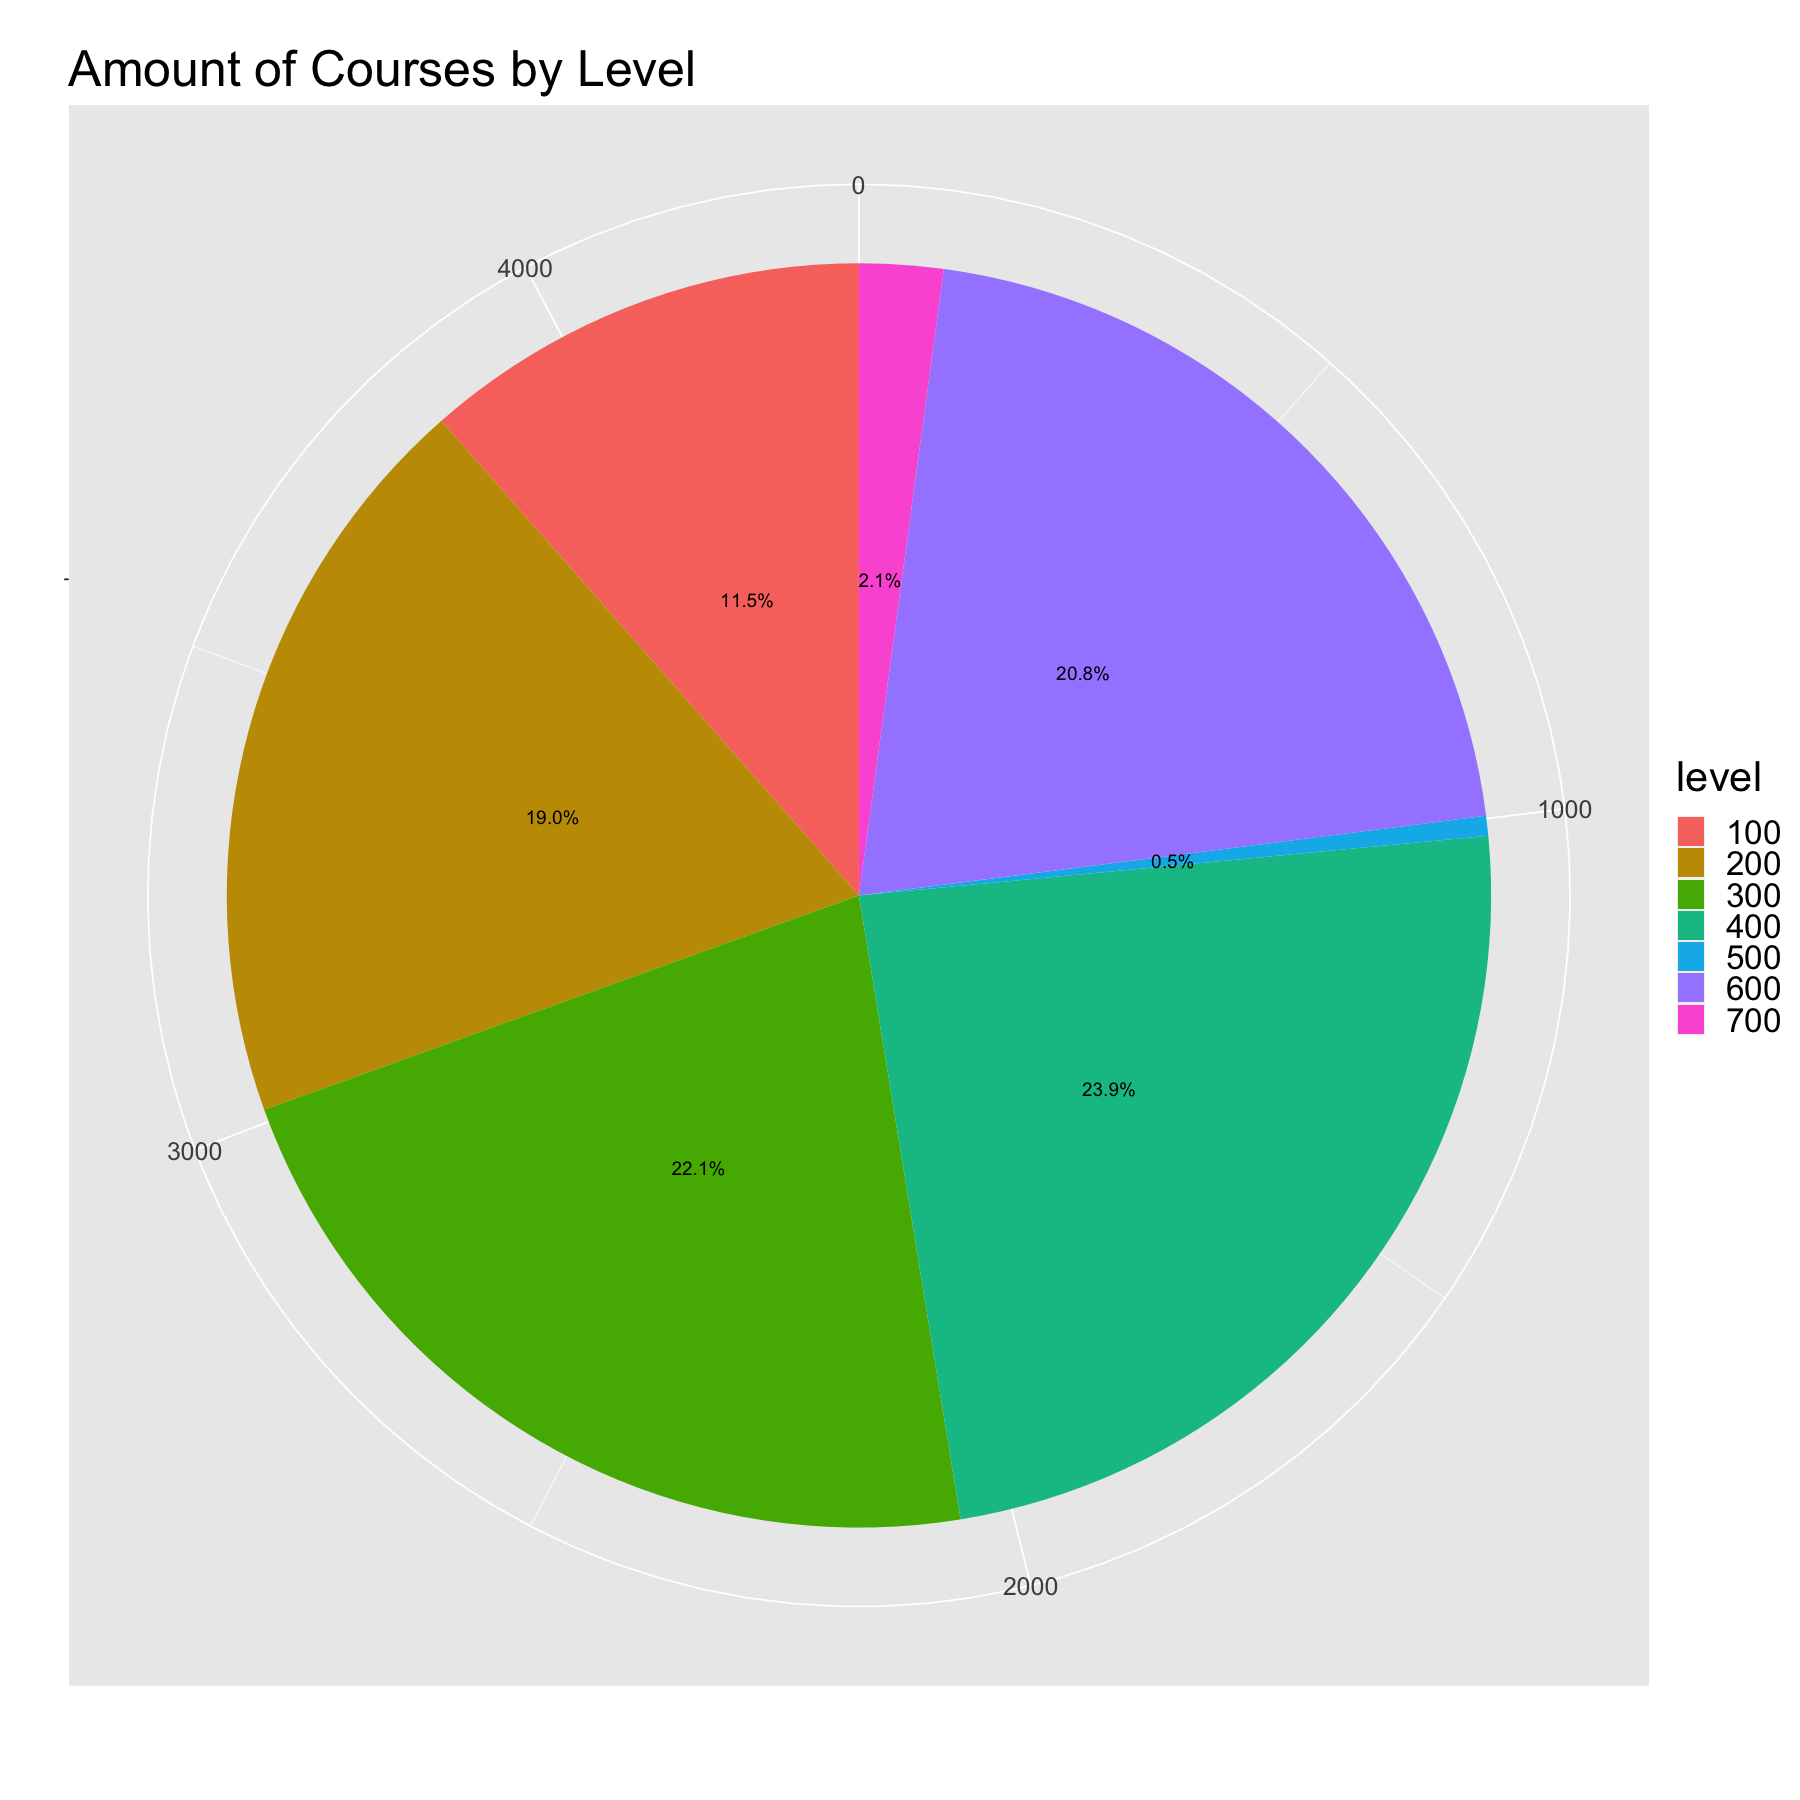

In [69]:
data_level <- subjects %>% 
                    select(course_code) %>%
                    mutate(level = str_c(substr(course_code, 5,5) , '00')) %>% 
                    group_by(level) %>% 
                    summarise(courses_have=n()) %>% 
                    filter(level >= 1) %>%
                    mutate(per = courses_have/sum(courses_have)) %>% 
                    mutate(labels = scales::percent(per))


pie_level_weight<- ggplot(data_level, aes(x="", y=courses_have, fill=level))+
        geom_bar(width = 1, stat = "identity") + 
        coord_polar("y", start=0) + 
        geom_text(aes(label = labels),position = position_stack(vjust = 0.5), size=4) +
        labs( title = "Amount of Courses by Level", x='', y='') + 
        theme(axis.text=element_text(size=20),
        axis.title=element_text(size=20,face="bold")) + base_theme

pie_level_weight

lecturer_id,id,name,email,title,room,phone,course_code
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
102,102,Stephan Lukosch,stephan.lukosch@canterbury.ac.nz,Professor | AIGI Researcher,,+6433691308,HITD690-21A (C)
609,609,Susan Bouterey,susan.bouterey@canterbury.ac.nz,Associate Professor,Logie 503,+6433694432,JAPA415-21S2 (C)
321,321,Tim Huber,tim.huber@canterbury.ac.nz,Senior Lecturer,West 319,+6433694124,PROD111-21S2 (C)


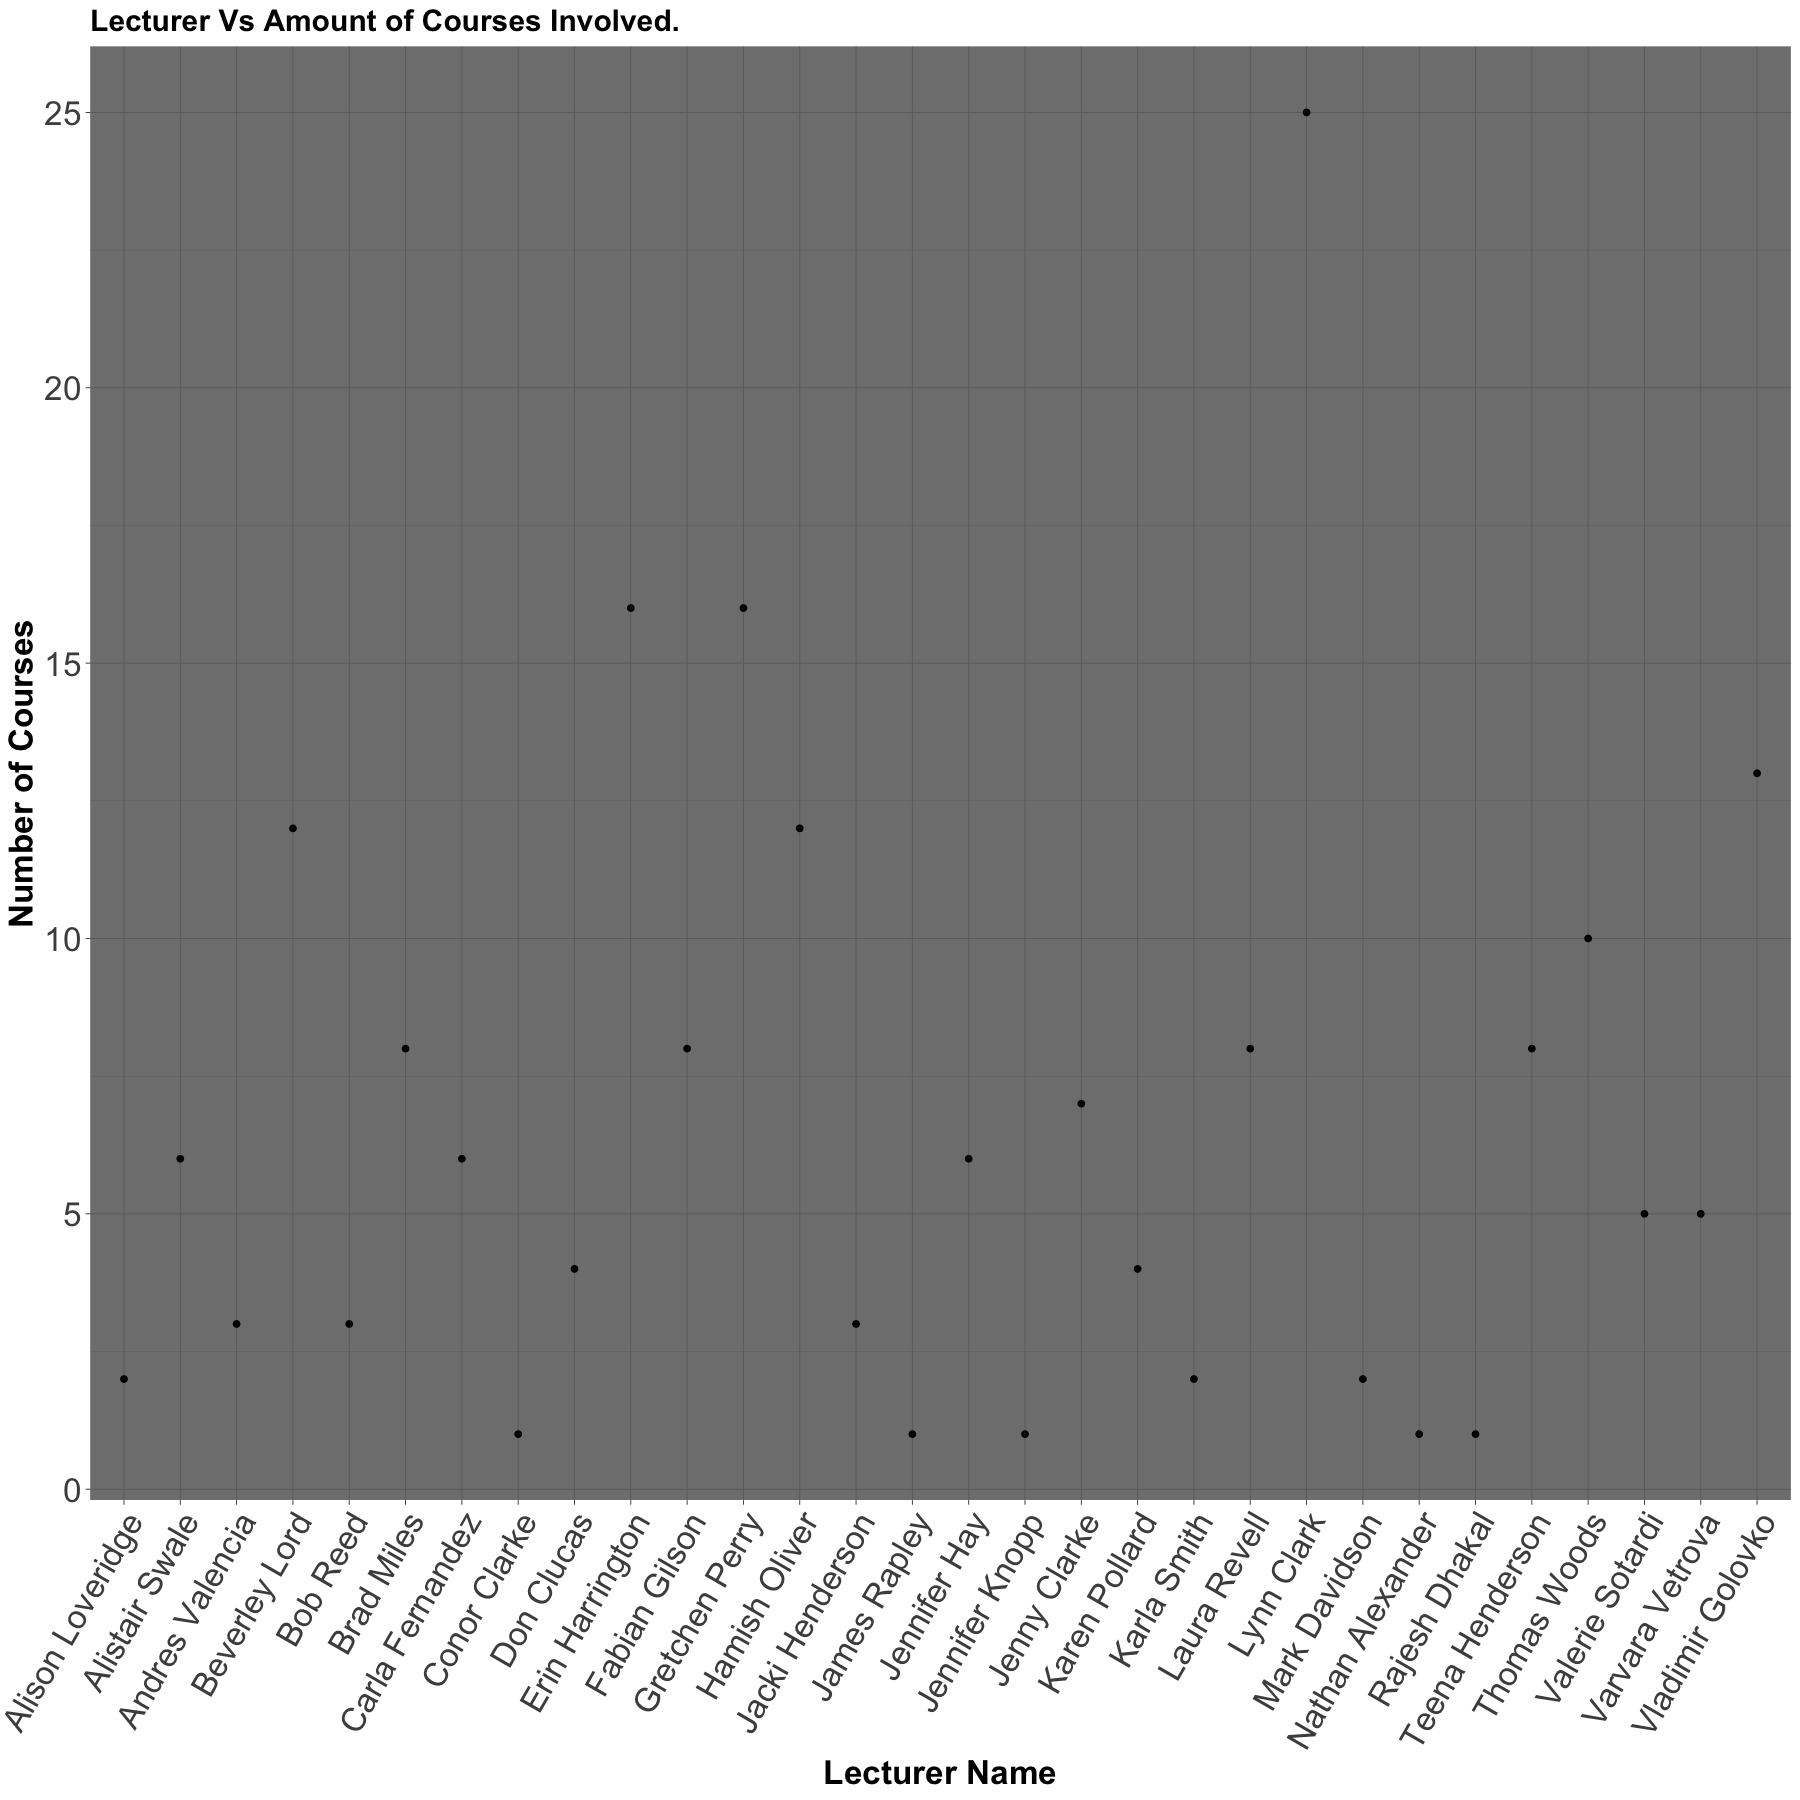

In [79]:
plot_df <- lecturer_information %>% mutate(lecturer_id=id) 
plot_df <- merge(x=plot_df, y=class_data, by='lecturer_id')
plot_df %>% sample_n(3)
data_lectrue_teach <- plot_df %>% 
    group_by(name) %>%
    summarise(number_courses_teach=n())

data_lectrue_teach %>% sample_n(30) %>%
                ggplot(aes(x=name, y=number_courses_teach)) +
                geom_point()  +
                theme_dark() + 
                theme(plot.title = element_text(size = 18, face = "bold")) + 
                labs(
                    title = "Lecturer Vs Amount of Courses Involved.",
                     x = "Lecturer Name",
                     y = "Number of Courses") + 
                theme(axis.text=element_text(size=20),
                axis.title=element_text(size=20,face="bold"),
                     axis.text.x=element_text(angle=60, hjust=1))

### Task (e): APIs (2 marks)

Identify a web service offering data through an API. Access the API using `httr` and collect the information you care about. Convert the data into a dataframe (or more than one). Represent it graphically in a meaningful way.

In [51]:
library(httr)
library(jsonlite)


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




# Information about API 

We chose pokeapi as the source of data for this task.
The api is in JSON format and contains information about all the pokemons to existance today.
We will get all the pokemons and some of their stats to make some visualisations.

In [52]:
get_all_pokemons <- function(url, pokemon_list){ # recursive function that follows pages of 20 pokemons at a time
    if (missing(url)){ 
        url = "https://pokeapi.co/api/v2/pokemon/" # as this is a recursive function we will set the url the first time, posterior executions will provide their own url
    }
    if (missing(pokemon_list)){ # if the pokemon list has not yet been set we will create a new empty data.frame to start getting all the pokemons.
        pokemon_list <- data.frame(id=integer(),
                               name=character(),
                               type=character(),
                               height=integer(),
                               hp=integer(),
                               attack=integer(),
                               defense=integer(),
                               special_attack=integer(),
                               special_defense=integer(),
                               speed=integer(),
                               url=character())
    }
    r <- GET(url) # calls a GET HTTP method on the url to gather
    jsonRespText <- content(r, as="text")   # parses text in PLAIN format
    jsonRespText <- fromJSON(jsonRespText) # parses result in JSON format 
    next_url <- jsonRespText$'next'  # checks whether there is a next page or not.
    for (i in jsonRespText$result$url){  # for each pokemon we will call the get pokemon function to get their stats.
        pokemon_list <- pokemon_list %>% add_row(get_pokemon(i)) # gets pokemon info and adds it to the pokemon list dataframe
    }
    if (!is.null(next_url)){ # if there is a next url we will call this same function in order to get the next page.
        return(get_all_pokemons(next_url, pokemon_list)) # recursive call.
    }
    return(pokemon_list) # returns the final pokemon list.
}
get_pokemon <- function(url){ # recives a pokeapi pokemon URL and retrieves its stats.
    r <- GET(url) # calls GET HTTP method in URL
    jsonRespText <- content(r, as="text") # parses text in PLAIN format
    jsonRespText <- fromJSON(jsonRespText) # parses result in JSON format 
    id <- jsonRespText$id # gets the pokemon ID
    name <- jsonRespText$name # gets the pokemon Name
    height <- jsonRespText$height # gets the pokemon height
    hp <- jsonRespText$stats %>% filter(stat$name=='hp') # gets the HP stat 
    attack <- jsonRespText$stats %>% filter(stat$name=='attack') # gets the ATTACK stat
    defense <- jsonRespText$stats %>% filter(stat$name=='defense') # gets the DEFENSE stat
    special_attack <- jsonRespText$stats %>% filter(stat$name=='special-attack') # gets the SPECIAL ATTACK stat
    special_defense <- jsonRespText$stats %>% filter(stat$name=='special-defense') # gets the SPECIAL DEFENSE stat
    speed <- jsonRespText$stats %>% filter(stat$name=='speed') # gets the pokemon's SPEED
    type <- jsonRespText$types %>% filter(slot==1)  # gets the pokemon type .
    data <- tibble(id=id, # assings all the values to a tibble 
                 name=name,
                 height=height,
                 hp=hp$base_stat,
                 attack=attack$base_stat,
                 defense=defense$base_stat,
                 special_attack=special_attack$base_stat,
                 special_defense=special_defense$base_stat,
                 speed=speed$base_stat,
                 type=type$type$name,
                 url=url
            )
    return(data) # returns the pokemon data tibble.
}

pokemons <- get_all_pokemons()

Write the pokemon information to a csv for further analysis.

In [ ]:
pokemons %>% write_csv('pokemons.csv')

Lets create some visualisations

In [53]:
pokemons <- read_csv('pokemons.csv')


── Column specification ────────────────────────────────────────────────────────
cols(
  id = col_double(),
  name = col_character(),
  type = col_character(),
  height = col_double(),
  hp = col_double(),
  attack = col_double(),
  defense = col_double(),
  special_attack = col_double(),
  special_defense = col_double(),
  speed = col_double(),
  url = col_character()
)




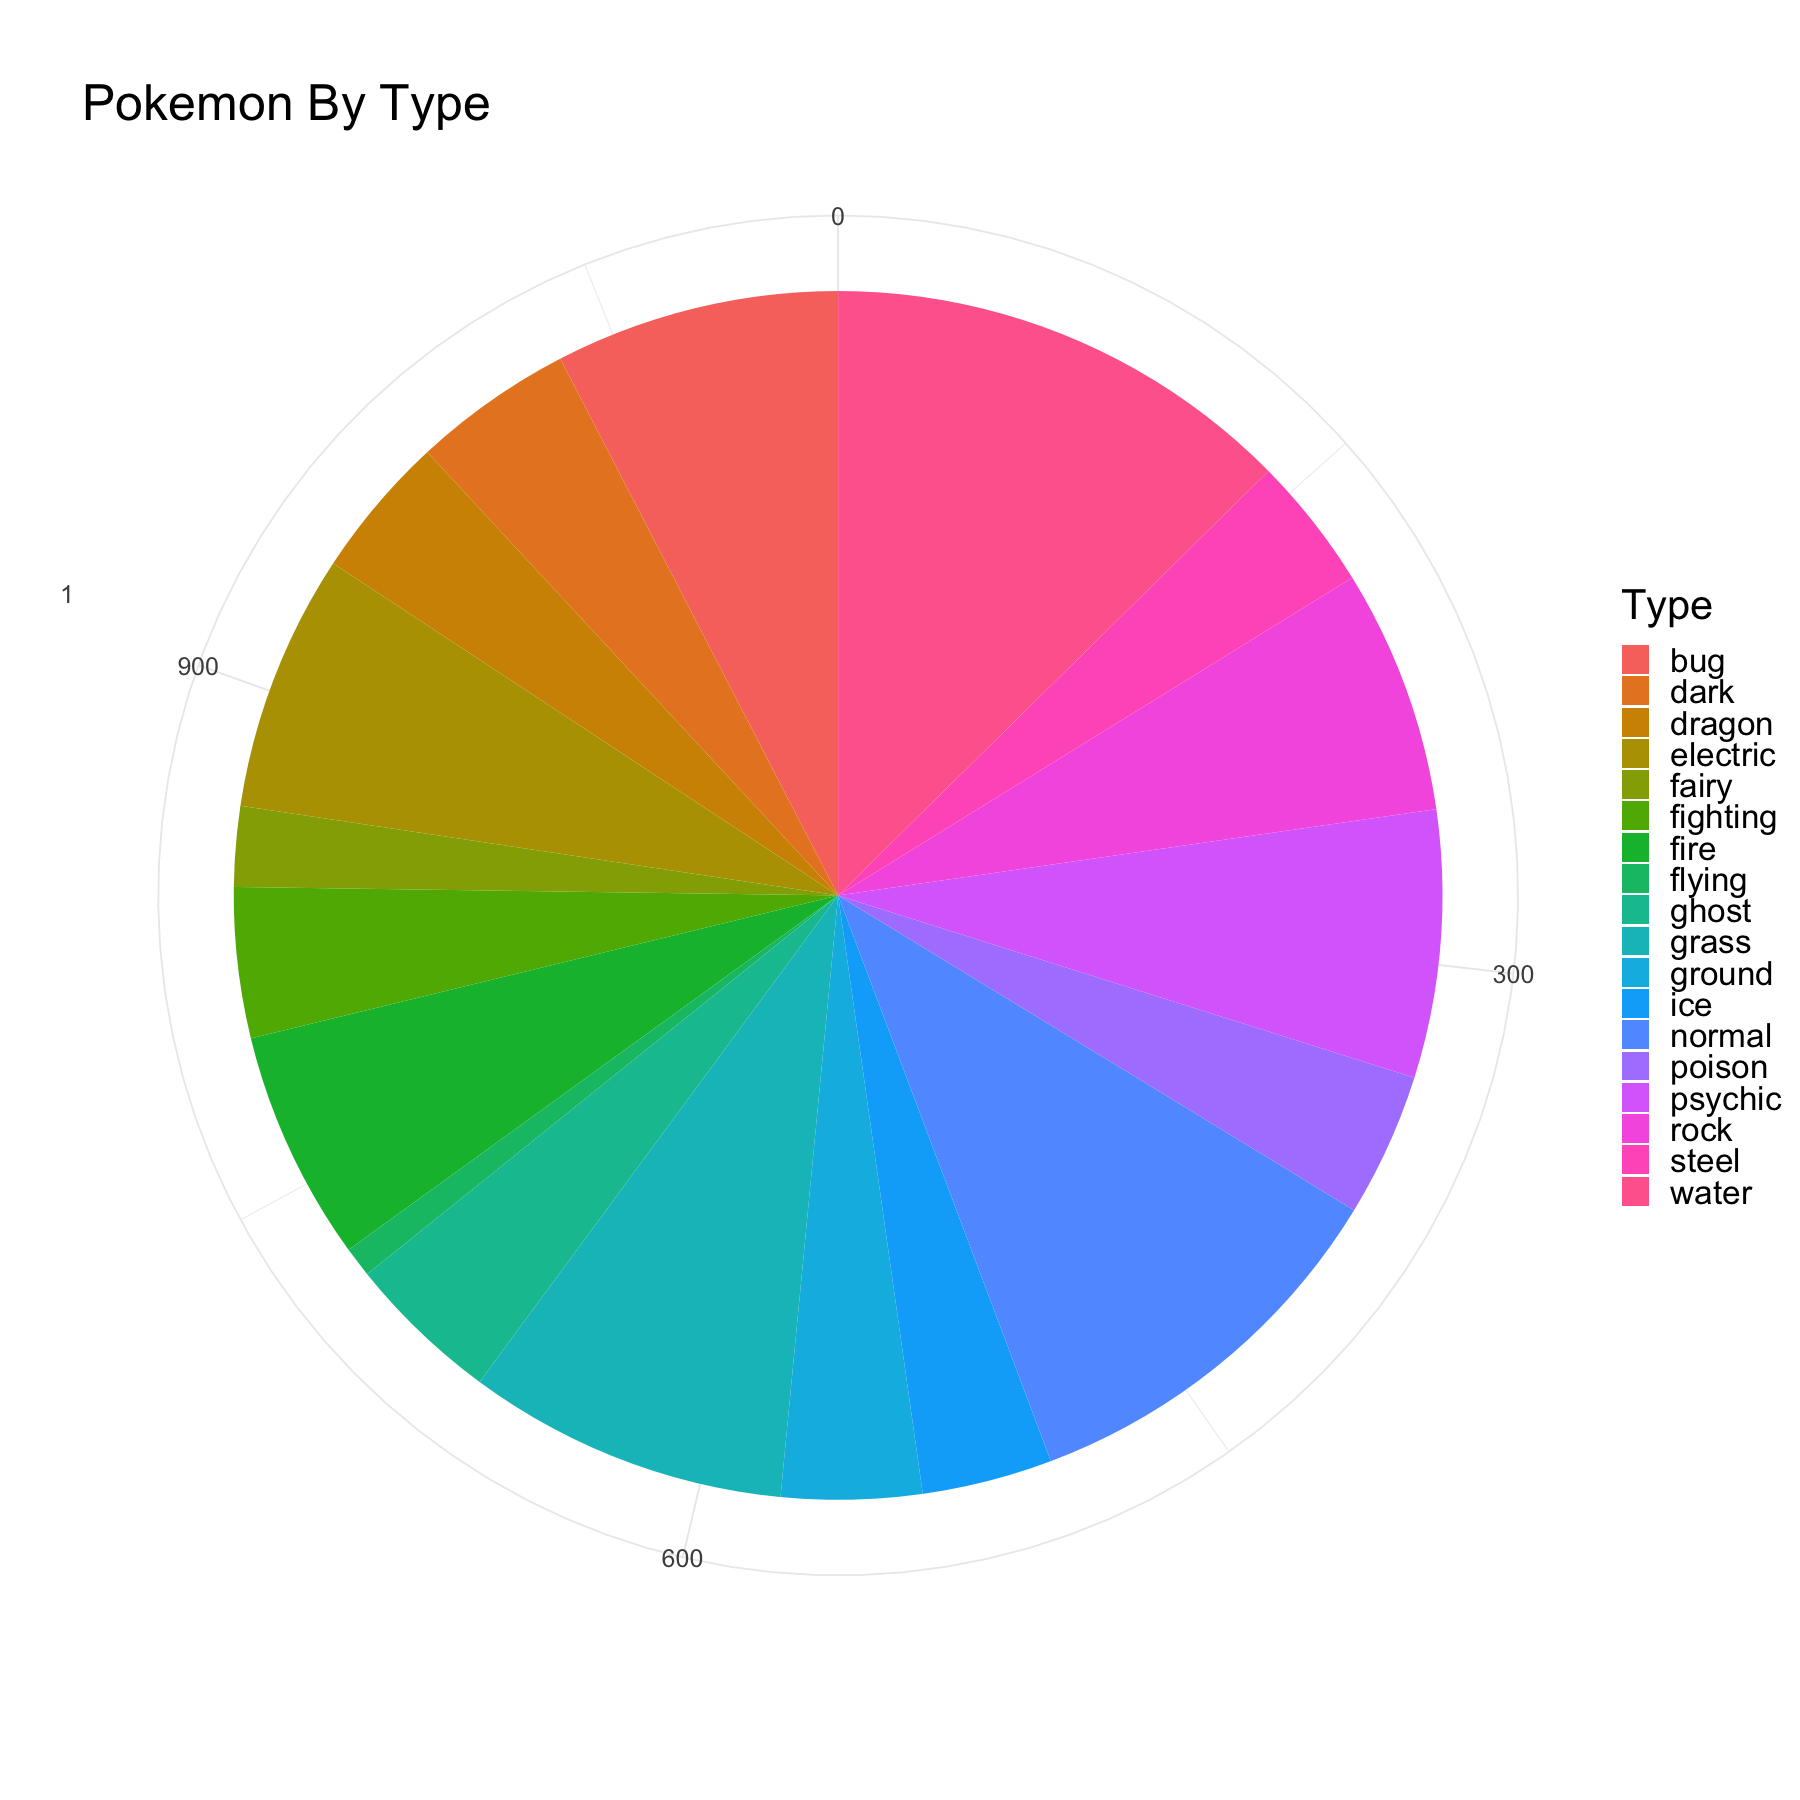

In [54]:
pokemons %>% ggplot(aes(x=factor(1), fill=type))+
                 geom_bar(width = 1)+
                 labs(title='Pokemon By Type',  #adding titles for the graph, x and y variables
                      x='', 
                      y='',
                     fill='Type') + 
                 coord_polar("y") + theme_minimal() + base_theme 

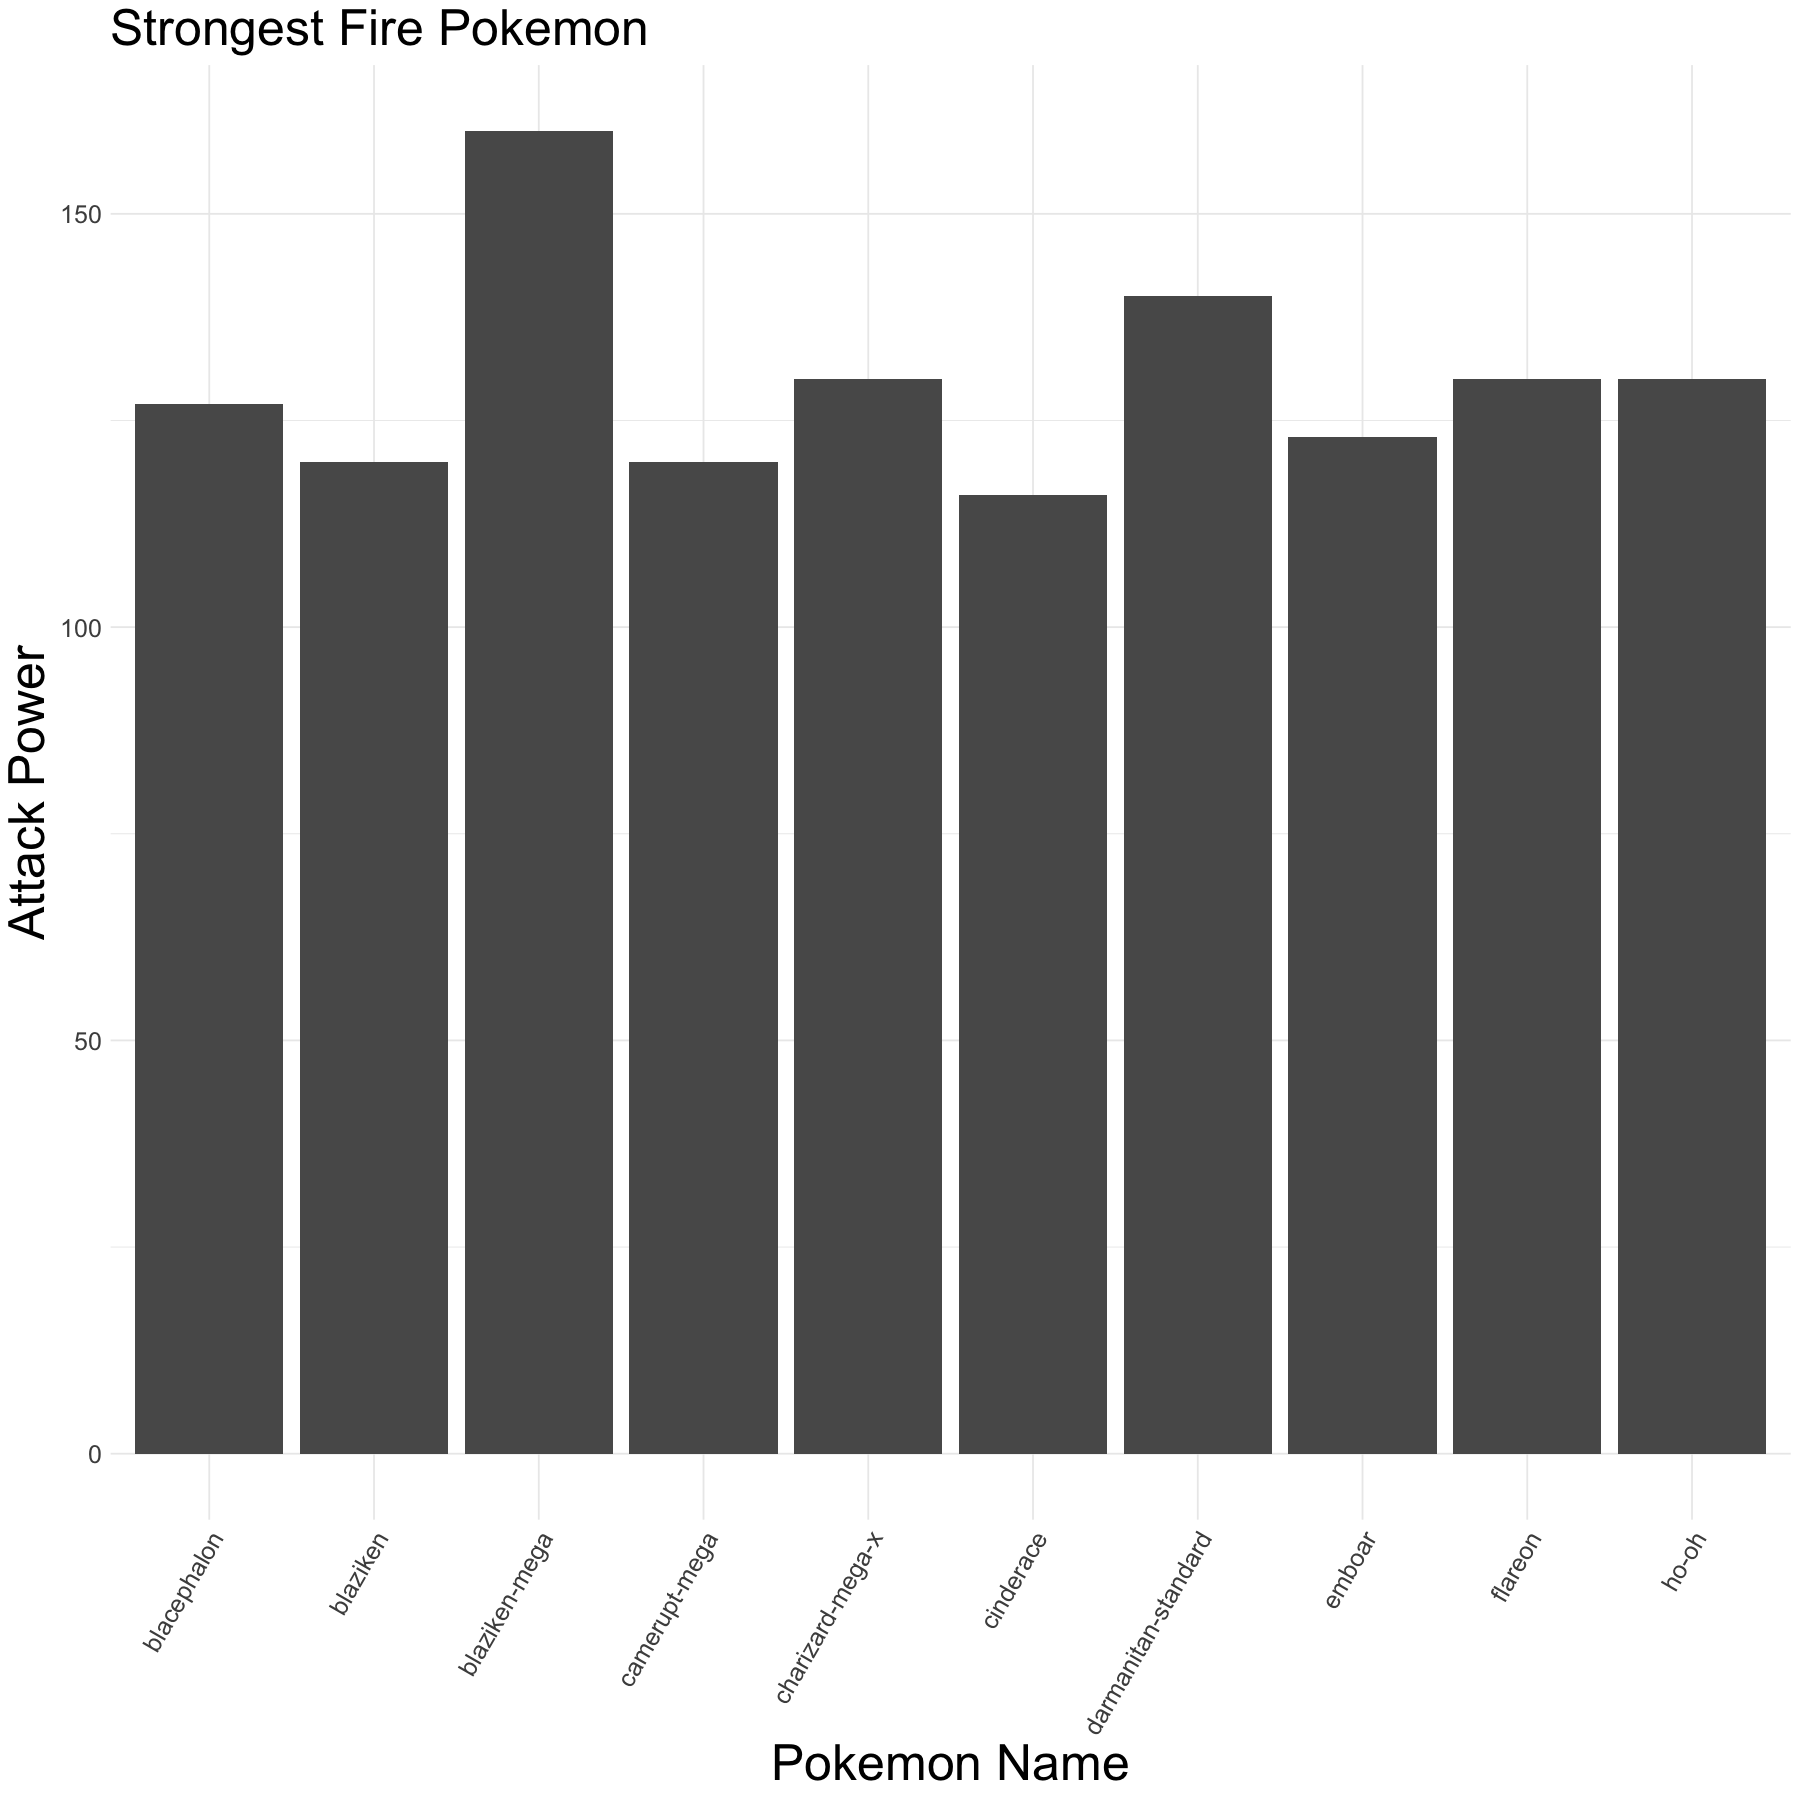

In [55]:
pokemons %>% filter(type=='fire') %>%
    arrange(desc(attack)) %>%
    slice(1:10) %>%
    ggplot(aes(x=name, y=attack))+
           geom_bar(stat='identity') +
           labs(title='Strongest Fire Pokemon',  #adding titles for the graph, x and y variables
                x='Pokemon Name', 
                y='Attack Power') + 
           theme_minimal() +
           theme(axis.text.x=element_text(angle=60, hjust=1)) + #adding x axis labels in an angle to fint the graph.
           base_theme   

### Comment, explain and present the work in a clear way (1 marks)